                                    Procesamiento de datos & Análisis exploratorio de datos

In [1]:
##Importamos las librerias con las que se trabajaran
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
##traemos el archivo a un dataframe 
df = pd.read_parquet('train.parquet')

In [3]:
##visualizamos la data
df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,0,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,0,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn


In [4]:
df.shape ##vemos el tamaño del archivo

(346479, 22)

In [5]:
df.isna().sum()  ##vemos la cantidad de valores faltantes para cada columna

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             71171
parking_options            126682
image_url                       0
description                     2
lat                          1722
long                         1722
state                           0
dtype: int64

In [6]:
##Eliminare las descripciones faltantes en el df ya que no afectan a la mejora del modelo de entrenamiento
df.dropna(subset='description', inplace=True)

In [7]:
df['description'].isna().sum() ##reviso que no hayan faltantes en descripcion 

0

In [8]:
##revisamos si hay duplicados en nuestro dataframe
df[df.duplicated()]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state


No hay filas duplicadas asi que seguimos buscando errores en nuestros datos

In [9]:
#analizamos graficamente los valores faltantes por columna y luego haremos una imputación
import missingno as msno

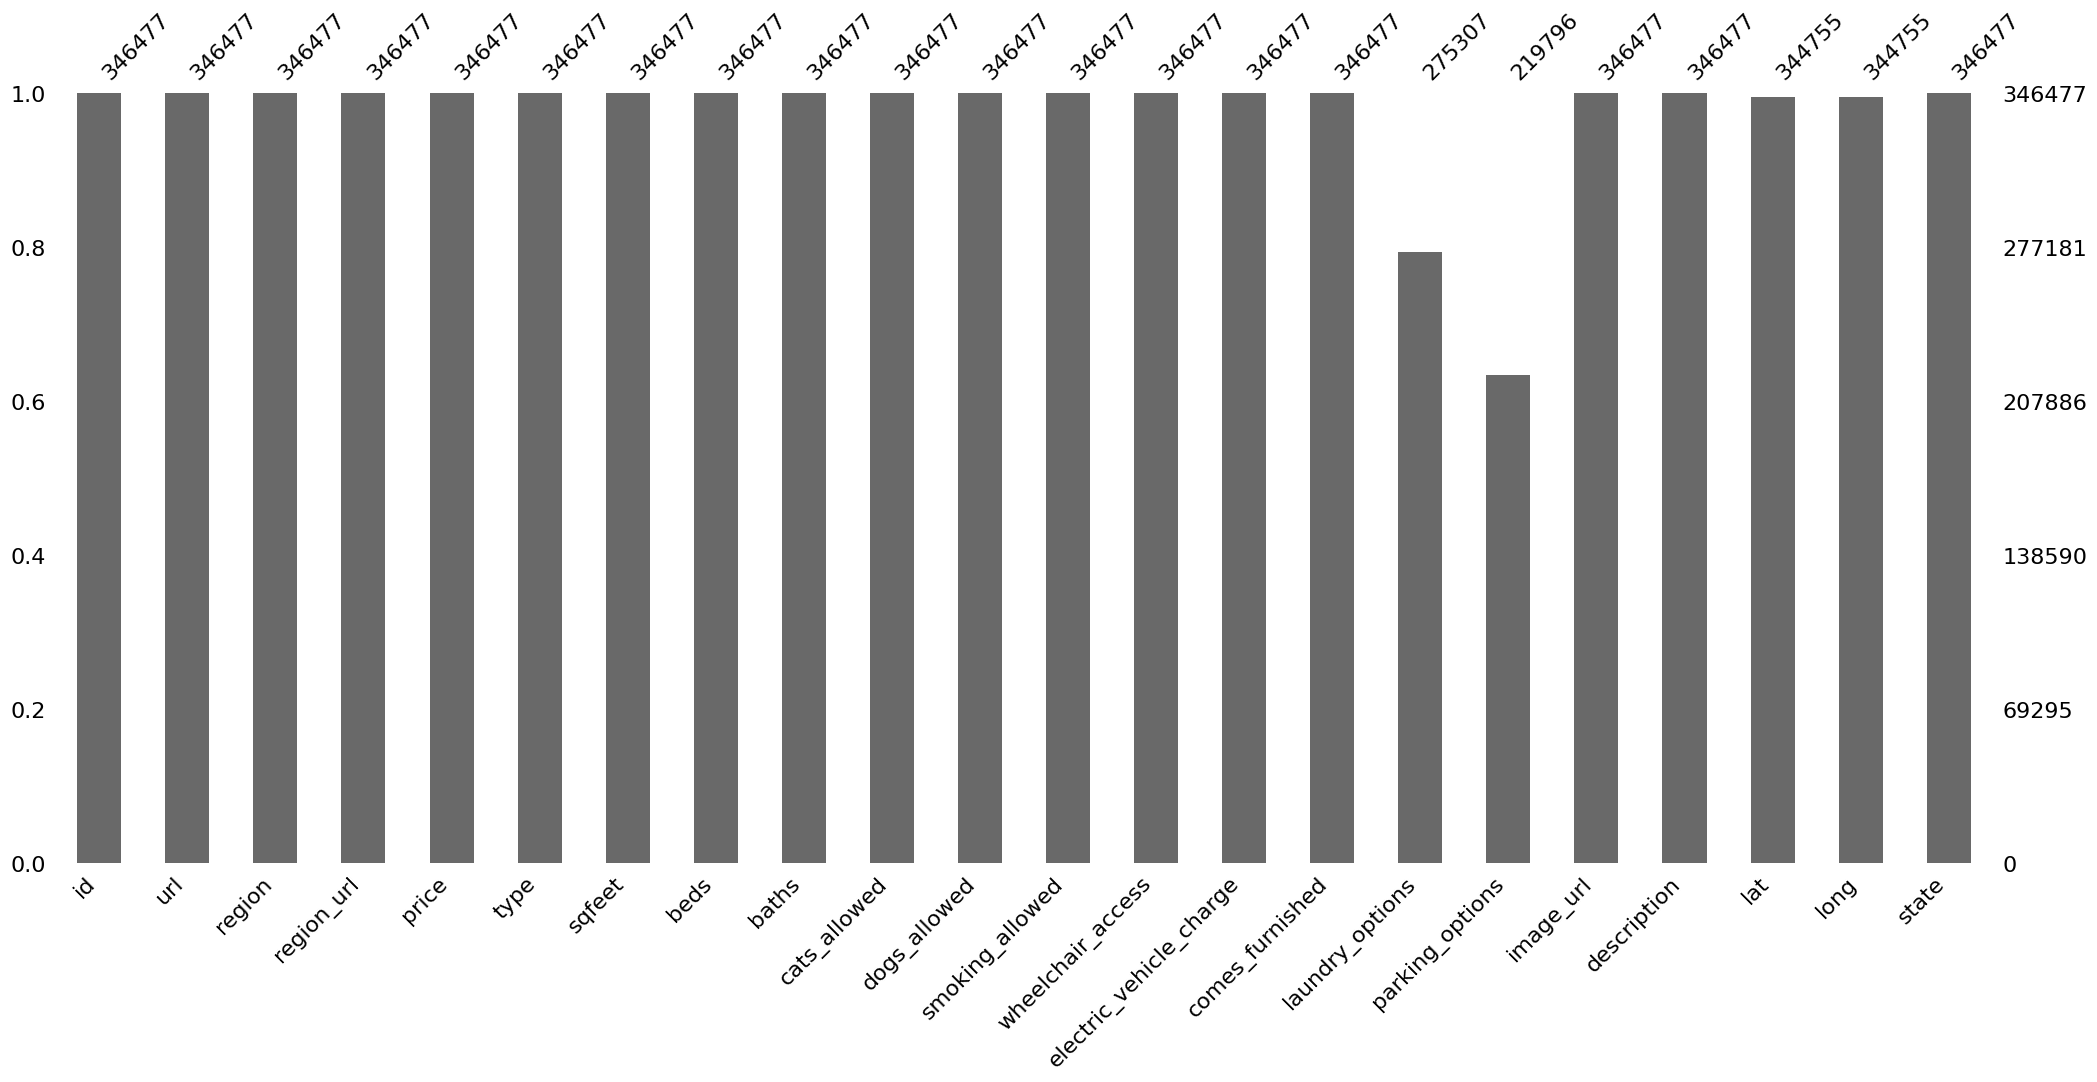

In [10]:
msno.bar(df)
plt.show()

Hare una evaluación en las columnas price y sqfeet ya que me interesan para aplicar luego en los modelos de machine learnig

In [11]:
df['price'][df.price == 0].count()  ##chequeo primero los precios una de las columnas que me interesan

1175

In [12]:
##esta vez aplico el mismo método que aplique en la columna precios a la columna sqfeel  
df['sqfeet'][df.sqfeet == 0].count()  ## observamos que hay 43 propiedades donde miden 0 metros cuadrados

43

In [13]:
##vemos el valor maximo en la columna price y la columna sqfeet 
print("El valor maximo de la columna price es: ", df.price.max())
print("El valor maximo para la columna en mts cuadrados es (sqfeet):", df.sqfeet.max())

El valor maximo de la columna price es:  2768307249
El valor maximo para la columna en mts cuadrados es (sqfeet): 8388607


Analisis breve:
1) Podemos apreciar que el la columna price hay propiedades donde el valor es 0, (no valen nada), se podria decir que las estan
regalando!?... A causa de este problema veremos que imputación podria hacer más adelante.
2) Existen propiedades que no tienen dimensiones su superficie es de 0 metros, son pocas y quizas son errores de el encargado 
que lleno los datasets. Haremos un modelo de imputación sobre estas columnas.


In [14]:
##usaremos el modelo kNN-imputer que utiliza un modelo de vecinos más cercanos para predecir los datos que no tienen valor.

# 1ero usamos la técnica de rango intercuartílico para dectectar y eliminar outlier

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR

print(Q1)
print(Q3)
print(IQR)
print(BI)
print(BS)

805.0
1395.0
590.0
-80.0
2280.0


In [15]:
print("La cantidad de registros totales en nuestro dataframe es de:", df.shape[0])
print("Cantidad de outliers en la columna price de nuestro dataframe es de:", df[(df['price']<BI) | (df['price']>BS)].shape[0])

La cantidad de registros totales en nuestro dataframe es de: 346477
Cantidad de outliers en la columna price de nuestro dataframe es de: 16903


In [16]:
##Eliminamos los outlier, aquellos valores que estan por debajo del BI y los que estan por encima del BS

df_filtro = (df['price']<BI) | (df['price']>BS) 

data = df[~df_filtro]

In [17]:
print("Tamaño de nuestro dataframe luego de eliminar los outlier en la columna prices: ", data.shape[0])

Tamaño de nuestro dataframe luego de eliminar los outlier en la columna prices:  329574


In [18]:
##observamos si siguen apareciendo valores atipicos en la columna sqfeet

data['sqfeet'][data.sqfeet == 0].count() ## ahora solo hay 39 

39

In [19]:
#Veremos la cantidad de outlier que aparecen el la columna sqfeet, usando el metodo de rango intercuartílico

Q1 = data['sqfeet'].quantile(0.25)
Q3 = data['sqfeet'].quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR

print(Q1)
print(Q3)
print(IQR)
print(BI)
print(BS)

750.0
1125.0
375.0
187.5
1687.5


In [20]:
print("La cantidad de registros totales en nuestro dataframe es de:", data.shape[0])
print("Cantidad de outliers en nuestro dataframe es de:", data[(data['sqfeet']<BI) | (data['sqfeet']>BS)].shape[0])

La cantidad de registros totales en nuestro dataframe es de: 329574
Cantidad de outliers en nuestro dataframe es de: 13019


In [21]:
##Eliminamos los outlier, aquellos valores que estan por debajo del BI y los que estan por encima del BS

df_filtro2 = (data['sqfeet']<BI) | (data['sqfeet']>BS) 

data = data[~df_filtro2]

In [22]:
print("Tamaño de nuestro dataframe luego de eliminar los outlier en la columna sqfeet: ", data.shape[0])

Tamaño de nuestro dataframe luego de eliminar los outlier en la columna sqfeet:  316555


In [23]:
data['price'][data.price == 0].count() ##observamos si siguen apareciendo propiedades con un valor de 0$

1128

In [24]:
data['sqfeet'][data.sqfeet == 0].count() ##observamos si siguen apareciendo propiedades con dimensiones de 0 metros cuadrados

0

                                                    Observación
*Las propiedades con dimensiones de 0 metros cuadrados eran outliers y fueron eliminados.

*Aún existen en nuestro dataframe en la columna prices un total de 1128 propiedades con un valor de 0$.

*Desconozco la razón por la que estas propiedades fueron ingestadas con un precio de 0, asi que las eliminare 
de mi set de entrenamiento.

In [25]:
data = data[(data['price'] > 0)]  ##me quedo con las propiedades donde los precios sean > 0

In [26]:
#vemos de que tamaño nos quedo
data.shape

(315427, 22)

In [27]:
print(data['price'][data.price == 0].count()) ##vemos si seguimos con el mismo problema

0


In [28]:
data.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7048013474,https://boise.craigslist.org/apa/d/very-nice-b...,boise,https://boise.craigslist.org,1350,house,1200,2,2.0,1,...,0,0,0,w/d in unit,detached garage,https://images.craigslist.org/00B0B_cPiJMEheZe...,Super cute row house in the Boise bench area. ...,43.5851,-116.2250,id
1,7043931179,https://cosprings.craigslist.org/apa/d/colorad...,colorado springs,https://cosprings.craigslist.org,1115,apartment,694,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00R0R_5XAoSKvfrz...,Windtree Apartment Homes currently has a spaci...,38.9137,-104.7800,co
2,7048254516,https://norfolk.craigslist.org/apa/d/virginia-...,norfolk / hampton roads,https://norfolk.craigslist.org,1129,apartment,900,2,2.0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00f0f_3ZbTFrsHpZ...,Call Today! show contact info Indian Lakes ...,36.7922,-76.1643,va
3,7041032577,https://phoenix.craigslist.org/nph/apa/d/phoen...,phoenix,https://phoenix.craigslist.org,1580,house,1469,3,2.0,1,...,0,0,0,w/d in unit,None,https://images.craigslist.org/00f0f_aXV5Dkd5qk...,Cody Anderson Two Brothers Realty License #: S...,33.5623,-112.0560,az
4,7048588701,https://nashville.craigslist.org/apa/d/antioch...,nashville,https://nashville.craigslist.org,995,apartment,700,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00606_gYOGKClOHv...,To schedule a tour We now book our tour appoin...,36.0595,-86.6592,tn


In [29]:
## ahora hare un filtro por las columnas que me interesan 'price',beds, y 'sqfeet'

data = data[['price','sqfeet','beds','baths','cats_allowed','electric_vehicle_charge','comes_furnished']]

In [30]:
data ##visualizamos

,price,sqfeet,beds,baths,cats_allowed,electric_vehicle_charge,comes_furnished
0,1350,1200,2,2.0,1,0,0
1,1115,694,1,1.0,1,0,0
2,1129,900,2,2.0,0,0,0
3,1580,1469,3,2.0,1,0,0
4,995,700,1,1.0,1,0,0
...,...,...,...,...,...,...,...
346474,672,660,1,1.0,1,0,0
346475,2122,1099,2,2.0,1,0,0
346476,1014,1104,2,2.0,1,0,0
346477,935,1050,2,2.0,0,0,0


In [31]:
data.shape

(315427, 7)

In [32]:
## creo la columna category_price

"""'low': Para precios entre 0 y 999 dólares.
'medium': Para precios entre 1000 y 1999 dólares.
'high': Para precios desde 2000 dólares en adelante.​Considerando esta categorización, el objetivo es predecir si una propiedad pertenece a la categoría de precios bajos (low).​"""

##valores de 0 para toda propiedad que no es 'low' y 1 para las propiedades que son 'low'.
data['category_price'] = data['price'].apply(lambda x: 1 if x <= 999 else 0)

In [33]:
data.head() #visualizamos

,price,sqfeet,beds,baths,cats_allowed,electric_vehicle_charge,comes_furnished,category_price
0,1350,1200,2,2.0,1,0,0,0
1,1115,694,1,1.0,1,0,0,0
2,1129,900,2,2.0,0,0,0,0
3,1580,1469,3,2.0,1,0,0,0
4,995,700,1,1.0,1,0,0,1


In [34]:
print("Existe un total de:", round(data[data.category_price == 0].shape[0]/ data.shape[0] * 100, 2),"%, de propiedades caras en E.U")
print("Existe un total de:", round(data[data.category_price == 1].shape[0] / data.shape[0] * 100, 2),"%, de propiedades baratas en E.U")

Existe un total de: 50.64 %, de propiedades caras en E.U
Existe un total de: 49.36 %, de propiedades baratas en E.U


                                                Modelo Machine Learning

In [35]:
##Importamos las librerias para trabajar con machine learning
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.pipeline import Pipeline
import joblib

#creamos las variables X e y que serviran para entrenar el modelo 

In [51]:
X = data[['sqfeet','beds','baths','cats_allowed','electric_vehicle_charge','comes_furnished']]

In [52]:
y = data['category_price']

In [53]:
##creamos el pipeline
pipeline_data = Pipeline([('rf', RandomForestClassifier(n_estimators=50, random_state=0)),])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
pipeline_data.fit(X_train, y_train)  #Entrenamos

In [41]:
joblib.dump(pipeline_data, 'modelo_random_forest.pkl', compress=1) #Guardamos el Pipeline 

['modelo_random_forest.pkl']

In [42]:
random_forest = joblib.load('modelo_random_forest.pkl')  ##cargamos el modelo que creamos

In [43]:
y_pred = np.where(random_forest.predict_proba(X_test) [:,1] > 0.2, 1, 0) #predecimos

In [44]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [46]:
print("Recall: ", recall)
print("Precision: ",precision)
print("Accuracy: ",accuracy)

Recall:  0.955058334665175
Precision:  0.6102238379217384
Accuracy:  0.6751894239609422


In [58]:
##Cargamos el archivo test

df_test = pd.read_parquet('test.parquet')

In [59]:
df_test.head()

,id,url,region,region_url,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7037609789,https://annarbor.craigslist.org/apa/d/wixom-ho...,ann arbor,https://annarbor.craigslist.org,manufactured,1344,3,2.0,0,0,...,0,0,0,w/d in unit,off-street parking,https://images.craigslist.org/00M0M_iNczP1nzIL...,"OPEN HOUSE TODAY! APPLY THIS WEEK, PUT A HOLDI...",42.5333,-83.5763,mi
1,7032406876,https://vermont.craigslist.org/apa/d/randolph-...,vermont,https://vermont.craigslist.org,apartment,1050,2,1.0,0,0,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00L0L_ecirmYBIzL...,"Think of it, you'll be first to get your mail....",43.9393,-72.5538,vt
2,7037022682,https://annarbor.craigslist.org/apa/d/ann-arbo...,ann arbor,https://annarbor.craigslist.org,apartment,1150,2,2.0,1,1,...,1,0,0,w/d in unit,carport,https://images.craigslist.org/00e0e_dPln2xjo9g...,One of Ann Arbor's most luxurious apartment co...,42.2492,-83.7712,mi
3,7048681802,https://fortcollins.craigslist.org/apa/d/fort-...,fort collins / north CO,https://fortcollins.craigslist.org,apartment,1280,2,2.5,1,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00L0L_jlektT5cSd...,"Specials! Move in before January 16th, 2020 an...",40.5501,-105.0350,co
4,7043597870,https://charlottesville.craigslist.org/apa/d/c...,charlottesville,https://charlottesville.craigslist.org,apartment,783,2,1.0,1,1,...,0,0,0,laundry on site,None,https://images.craigslist.org/00D0D_cXa4KbZ6ox...,Barracks West Apartments & Townhomes in Charlo...,38.0936,-78.5611,va


In [60]:
df_test.isna().isnull().sum() ##chequeamos que no hayan valores nulos 

id                         0
url                        0
region                     0
region_url                 0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
image_url                  0
description                0
lat                        0
long                       0
state                      0
dtype: int64

In [61]:
df_test.shape

(38498, 21)